In [1]:
!pip install -q -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
!pip install evaluate

In [5]:
import nltk
import evaluate
import numpy as np
from datasets import load_dataset
import os,torch
from huggingface_hub import HfFolder, login

In [6]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, DebertaV2Model, DebertaV2Tokenizer, AdamW
from transformers import  AutoConfig, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, auc, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn

In [22]:
ds = load_dataset('csv', data_files='/content/Jailbreakds.csv')

In [29]:
from jldataprocessing import *
from debertaclassifier import *

In [30]:
config = {
    'model_name': 'microsoft/deberta-v3-small',
    'max_length': 128,
    'batch_size': 32,
    'learning_rate': 2e-5,
    'epochs': 10,
    'dropout_rate': 0.2,
    'hidden_dropout_rate': 0.3,
    'outputmdlpath' : '/content/finetunedmdl',

}

In [32]:
#Calculate class weights
labelcol = 'jailbreak'
ds_df = ds['train'].to_pandas()
class_weights = calculate_class_weights(ds_df[labelcol].values)
config['class_weights'] = class_weights
print("\nClass Weights:")
print(class_weights)


# Calculate class distribution
class_distribution = ds_df[labelcol].value_counts()
print("\nClass Distribution:")
print(class_distribution)
print("\nClass Distribution (%):")
print(class_distribution / len(ds_df) * 100)


Class Weights:
tensor([0.9425, 1.0650])

Class Distribution:
jailbreak
False    3789
True     3353
Name: count, dtype: int64

Class Distribution (%):
jailbreak
False    53.052366
True     46.947634
Name: count, dtype: float64


# Model Training and Evaluation

In [38]:
from evalmetrics import plot_metrics

def train_model(config,model,train_loader, val_loader, test_loader, num_epochs=10,patiencestep=3,lrate=2e-5,weight_decay=0.01,factorrate=0.1,max_norm=1.0):
    """
    # learning rate scheduler that reduces the learning rate when the validation metric (recall) plateaus. This helps to fine-tune the model and prevent overfitting.
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    class_weights = config['class_weights'].to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = AdamW(model.parameters(), lr=lrate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=factorrate, patience=patiencestep, verbose=True
    )

    # early stopping and metrics initialization
    best_val_recall = 0
    patience = patiencestep
    patience_counter = 0

    early_stopping = EarlyStopping(patience=patiencestep)

    train_losses = []
    val_losses = []
    val_recalls = []
    all_labels = []
    all_probs = []

    for epoch in range(config['epochs']):
        print(f'\nEpoch {epoch + 1}/{config["epochs"]}')

        # Training Mode
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs, _ = model(input_ids, attention_mask, labels-labels)

            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
            optimizer.step()
            #scheduler.step()

            total_train_loss += loss.item()
            #progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Mode
        val_metrics = evaluate_model(
            model,
            val_loader,
            device,
            class_weights,
            criterion
        )
        val_losses.append(val_metrics['loss'])
        val_recalls.append(val_metrics['recall'])

        # Assign val_preds from the validation metrics returned in val_metrics
        val_preds = val_metrics['predictions']
        val_labels = val_metrics['labels']

        # Extend with validation labels
        all_labels.extend(val_metrics['labels'])
        all_probs.extend(val_metrics['probabilities'])
        #all_probs.extend(val_preds)

        print(f'Epoch {epoch + 1}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {val_metrics["loss"]:.4f}')
        print('\nValidation Classification Report:')
        print(classification_report(val_labels, val_preds))
        #print(f'Val Recall: {val_metrics["recall"]:.4f}')

        scheduler.step(val_metrics['recall'])

        if val_metrics['recall'] > best_val_recall:
            best_val_recall = val_metrics['recall']
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Final evaluation on test set
    test_metrics = evaluate_model(
        model,
        test_loader,
        device,
        class_weights,
        criterion
    )

    print('\nTest Set Results:')
    print(f'Test Loss: {test_metrics["loss"]:.4f}')
    print('\nTest Classification Report:')
    print(classification_report(test_metrics['labels'], test_metrics['predictions']))

    # Plot confusion matrix
    plot_metrics(train_losses, val_losses, all_labels, all_probs, val_preds, test_metrics)

    #return model
    return train_losses, val_losses, val_recalls, model


def evaluate_model(model, data_loader, device, class_weights=None, criterion=None):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_indices = []
    # disables gradient calculations as only evaluation is being done and NOT training.
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            indices = batch['idx']

            logits, _ = model(input_ids, attention_mask)
            #outputs = model(input_ids, attention_mask)
            if criterion is not None:
                loss = criterion(logits, labels)
                #loss = criterion(outputs, labels)
                total_loss += loss.item()

            # convert logits into probabilities using softmax
            probs = torch.softmax(logits, dim=1) #
            #probs = torch.softmax(outputs, dim=1)

            #get class with highest probablity using predicted class
            preds = torch.argmax(logits, dim=1)
            #preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_indices.extend(indices.numpy())

    metrics = {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'indices': all_indices,
        'recall': recall_score(all_labels, all_preds),
        'loss': total_loss / len(data_loader) if criterion is not None else None
    }

    return metrics


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
model = CustomDebertaClassifier().to(device)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training set size: 4284
Validation set size: 1429
Test set size: 1429

Epoch 1/10


Epoch 1/10: 100%|██████████| 268/268 [02:11<00:00,  2.03it/s]


Epoch 1:
Training Loss: 0.6220
Validation Loss: 0.4693

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       758
           1       0.80      0.73      0.76       671

    accuracy                           0.79      1429
   macro avg       0.79      0.78      0.78      1429
weighted avg       0.79      0.79      0.79      1429


Epoch 2/10


Epoch 2/10: 100%|██████████| 268/268 [02:11<00:00,  2.03it/s]


Epoch 2:
Training Loss: 0.4792
Validation Loss: 0.4920

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       758
           1       0.81      0.76      0.78       671

    accuracy                           0.80      1429
   macro avg       0.80      0.80      0.80      1429
weighted avg       0.80      0.80      0.80      1429


Epoch 3/10


Epoch 3/10: 100%|██████████| 268/268 [02:13<00:00,  2.01it/s]


Epoch 3:
Training Loss: 0.4250
Validation Loss: 0.4507

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       758
           1       0.73      0.85      0.79       671

    accuracy                           0.78      1429
   macro avg       0.79      0.79      0.78      1429
weighted avg       0.79      0.78      0.78      1429


Epoch 4/10


Epoch 4/10: 100%|██████████| 268/268 [02:13<00:00,  2.00it/s]


Epoch 4:
Training Loss: 0.3846
Validation Loss: 0.5915

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76       758
           1       0.71      0.90      0.79       671

    accuracy                           0.78      1429
   macro avg       0.80      0.79      0.78      1429
weighted avg       0.80      0.78      0.78      1429


Epoch 5/10


Epoch 5/10: 100%|██████████| 268/268 [02:14<00:00,  1.99it/s]


Epoch 5:
Training Loss: 0.3452
Validation Loss: 0.5374

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       758
           1       0.72      0.89      0.79       671

    accuracy                           0.78      1429
   macro avg       0.80      0.79      0.78      1429
weighted avg       0.80      0.78      0.78      1429


Epoch 6/10


Epoch 6/10: 100%|██████████| 268/268 [02:14<00:00,  2.00it/s]


Epoch 6:
Training Loss: 0.3340
Validation Loss: 0.5936

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77       758
           1       0.72      0.86      0.78       671

    accuracy                           0.78      1429
   macro avg       0.79      0.78      0.78      1429
weighted avg       0.79      0.78      0.78      1429


Epoch 7/10


Epoch 7/10: 100%|██████████| 268/268 [02:14<00:00,  1.99it/s]


Epoch 7:
Training Loss: 0.3069
Validation Loss: 0.5359

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       758
           1       0.74      0.85      0.79       671

    accuracy                           0.79      1429
   macro avg       0.79      0.79      0.79      1429
weighted avg       0.79      0.79      0.78      1429

Early stopping triggered!

Test Set Results:
Test Loss: 0.5132

Test Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.80       758
           1       0.75      0.84      0.79       671

    accuracy                           0.79      1429
   macro avg       0.80      0.80      0.79      1429
weighted avg       0.80      0.79      0.80      1429



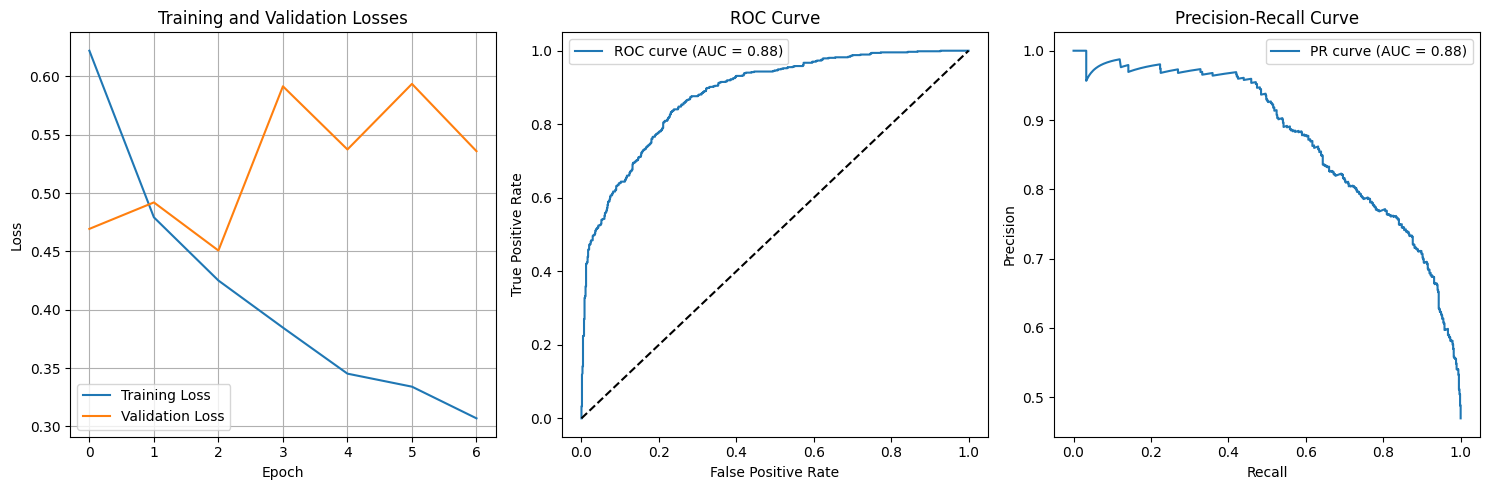

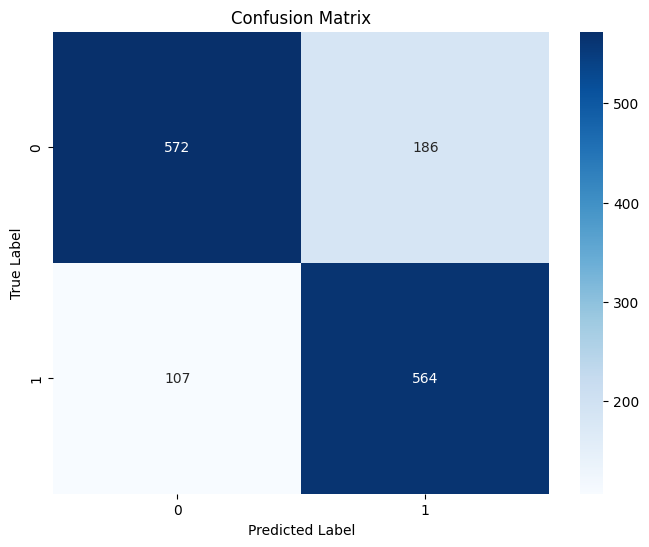

In [44]:
train_dataset, val_dataset, test_dataset = create_data_splits(
        texts=ds['train']['prompt'],
        labels=ds['train']['jailbreak'],
        tokenizer=tokenizer,
        test_size=0.20,
        val_size=0.25
    )

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16
)

# train model
train_losses, val_losses, val_recalls, _ = train_model(
     config, model, train_loader, val_loader, test_loader
  )

# Load best model and evaluate by loading model weights onto the correct device
state_dict = torch.load('best_model.pt', map_location=device, weights_only=True)

# Load  weights and other necessary state information into the model
model.load_state_dict(state_dict)
test_metrics = evaluate_model(model, test_loader, device)